In [1]:
%pip install datasets einops  &>> install.log

Note: you may need to restart the kernel to use updated packages.


/home/vedant/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Reusing dataset cifar10 (/home/vedant/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
100%|██████████| 2/2 [00:00<00:00, 664.50it/s]
/tmp/ipykernel_942580/1864808139.py:14: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img.resize((W * cols * 4, H * rows * 4), Image.NEAREST)


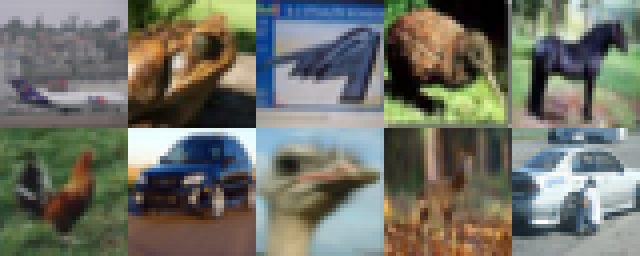

In [2]:
# Load 10 images
from PIL import Image
from datasets import load_dataset

cifar10 = load_dataset('cifar10')
W = H = 32
cols, rows = 5, 2
img = Image.new('RGB', size=(W * cols, H * rows))
for i in range(10):
  # ignore label
  im = cifar10['train'][i]['img']
  left, top = W * (i % cols), H * (i // cols)
  img.paste(im, (left, top))
img.resize((W * cols * 4, H * rows * 4), Image.NEAREST)

In [3]:
import torch
import math

def lin_schedule(start, end, T):
  beta = torch.linspace(start, end, steps=T)
  alpha = 1 - beta
  alpha_bar = torch.cumprod(alpha, dim=0)
  return alpha_bar

# > In particular, we
# > selected s such that \sqrt{B_0}
# > was slightly smaller than the pixel
# > bin size 1/127.5, which gives  s = 0.008
def cos_schedule(T, s = 0.008):
  alpha_bar = torch.arange(0, T)
  assert alpha_bar.shape == (T,)

  alpha_bar = ((alpha_bar / T) + s) / (1 + s)
  alpha_bar *= (math.pi / 2)
  alpha_bar = alpha_bar.cos() ** 2
  return alpha_bar

In [4]:
# > We set T = 1000 without a sweep, and we chose a linear
# > schedule from β_1 = 10−4  to β_T = 0.02. [0]
T = 1000
lin_start = 1e-4
lin_end = 0.02

# Alternate parameters for experimentation
# The cosine schedule always starts at 1 and ends at 0
# with a smooth linear slope in the middle
# Since `alpha_bar` is a cumulative product in the linear schedule
# If we decrease the # of steps, we need to increase `lin_end` proportionally
# to end @ 0
# T = 100
# Increasing this parameter steepens the slope
# lin_start = 1e-4 
# lin_end = 0.2

# Note: Modifying T should not change the curve for the cosine schedule,
# (& if you tweak the linear schedule parameters, that curve won't change either)
# so the sample image will be degraded at the same rate

lin_alpha_bars = lin_schedule(start=lin_start, end=lin_end, T=T)
cos_alpha_bars = cos_schedule(T)

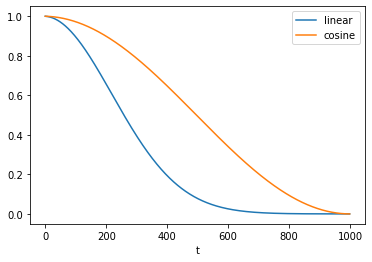

In [5]:
import matplotlib.pyplot as plt

x = torch.arange(0, T)

plt.plot(x, lin_alpha_bars, label="linear")
plt.plot(x, cos_alpha_bars, label="cosine")
plt.xlabel("t")
plt.legend()
plt.show()

Because the cosine schedule decreases $\bar{a}$ more slowly, the co-efficient of the $\epsilon$ term increases more slowly.

Thus, noise is injected into the image more slowly.

$q(x_t|x_0) = \mathcal{N}(x_t;\sqrt{\bar{a}_t}x_0,(1-\bar{a}_t)\mathbb{I})$

$x_t = \sqrt{\bar{a}_t}x_0 + \sqrt{1 - \bar{a}_t}\epsilon$

In [6]:
from einops import rearrange
import numpy as np

def q_xt_x0(t, x_0, abar):
  scaled = x_0 * abar[t].sqrt()
  # eps ~ N(0, I) [1]
  eps = torch.randn_like(x_0)
  noise = (1 - abar[t]).sqrt() * eps
  return scaled + noise

def img_to_tensor(img):
    scaled_0_to_1 = np.array(im.convert('RGB')) / 255
    channels_first = rearrange(scaled_0_to_1, 'h w c -> c h w')
    neg_one_to_pos_one = channels_first * 2 - 1
    return torch.tensor(neg_one_to_pos_one)

def tensor_to_image(t):
  channels_last = rearrange(t, "c h w -> h w c")
  zero_to_255 = ((channels_last + 1) / 2).clip(0, 1) * 255
  return Image.fromarray(np.array(zero_to_255).astype(np.uint8))

Image dimensions: 32x32
Tensor shape: torch.Size([3, 32, 32])


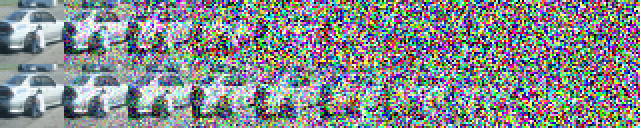

In [7]:
sample_img = cifar10['train'][0]['img']
# sample_img = sample_img.resize((64, 64), Image.NEAREST)
print(f"Image dimensions: {sample_img.height}x{sample_img.width}")
sample_img = img_to_tensor(sample_img)
print(f"Tensor shape: {sample_img.shape}")
samples = 10

def q_samples(img, abar, samples, T):
    idxs = torch.linspace(0, T - 1, steps=samples).int()
    ims = []
    for idx in idxs:
      im = q_xt_x0(idx, img, abar)
      ims.append(im)
    return ims

def compare_schedules(img, samples, T, abars):
  all_samples = []
  for abar in abars:
    all_samples.append(q_samples(img, abar, samples, T))

  _, W, H = img.shape
  image = Image.new('RGB', size=(W*samples, H * len(abars)))
  for row, schedule_samples in enumerate(all_samples):
    for col, sample in enumerate(schedule_samples):
      sample = tensor_to_image(sample)
      image.paste(sample, (W * col, H * row))
  return image

comparison = compare_schedules(sample_img, samples, T, [lin_alpha_bars, cos_alpha_bars])
W, H = comparison.width, comparison.height
# TODO: This looks a bit suspicious. Specifically,
# it seems the car is getting destroyed a bit too quickly in both schedules
# BUT, this might just be because the car image is low resolution
comparison.resize((W*2, H*2), Image.Resampling.NEAREST)

$$
p_\theta(x_{t-1}|x_t) := \mathcal{N}(x_{t-1};\mu_\theta(x_t,t),\Sigma_\theta(x_t,t))
$$

The original paper didn't learn the variance. It just fixed it to $\sigma^2_t\bf{I}$ where $\sigma^2_t$ could either be 
- $\beta_t$ (the upper bound)
- $\tilde{\beta_t}$ (the lower bound)

where $\tilde{\beta_t}$ represents the accumulated variance.

$$
\tilde{\beta_t} = \frac{1-\bar{a}_{t-1}}{1-\bar{a}_t} \cdot \beta_t
$$

and

$$
\beta_t = 1 - \frac{\bar{a}_t}{\bar{a}_{t-1}}
$$

In [13]:
from torch import Tensor
from math import floor

# Testing my implementation of alpha_bar vs OpenAI's
# The numerics generally seem a bit off (look for SUSPICIOUS)

# My code
def cos_schedule_inclusive(T, s = 0.008):
  alpha_bar = torch.arange(0, T + 1)
  assert alpha_bar.shape == (T + 1,)

  alpha_bar = ((alpha_bar / T) + s) / (1 + s)
  alpha_bar *= (math.pi / 2)
  alpha_bar = alpha_bar.cos() ** 2
  return alpha_bar

def beta_and_agg_beta(alpha_bar, max_beta=0.999): 
  alpha_bar_next = alpha_bar[1:]
  alpha_bar_prev = alpha_bar[:-1]
  beta = 1 - (alpha_bar_next / alpha_bar_prev)
  beta = beta.clip(max=max_beta)
  agg_beta = beta * ((1 - alpha_bar_prev) / (1 - alpha_bar_next))
  return beta, agg_beta

# OpenAI code
def cos_alpha_bar(t):
  return math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2


def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)

# Testing code
def test_eq(a, b, thresh=1e-7, identical=False, test_name="unknown"):
    assert len(a) == len(b)
    for idx, (x, y) in enumerate(zip(a, b)):
        diff = abs(x - y)
        if diff > thresh:
            print(f"Diff: {x - y} between {x} and {y} @ {idx} for test {test_name}")
        if identical:
            if isinstance(x, Tensor):
                x = x.item()
            assert x - y == 0
            
beta_and_agg = {}
        
# Testing code
for T in [100, 1000]:
  # Tweaking s from 0.008 causes testing to throw an error (which is good)
  my_cos_alpha_bar = cos_schedule_inclusive(T, s = 0.008)
  openai_cos_alpha_bar = [cos_alpha_bar(i / T) for i in range(T + 1)]

  my_cos_alpha_bar_list = my_cos_alpha_bar.tolist()
  test_eq(my_cos_alpha_bar, my_cos_alpha_bar_list, identical=True, test_name=f"tensor_list_{T}_identical")
  test_eq(my_cos_alpha_bar_list, openai_cos_alpha_bar, test_name=f"list_list_{T}", thresh=2e-7)
  test_eq(my_cos_alpha_bar, openai_cos_alpha_bar, test_name=f"tensor_list_{T}", thresh=2e-7)

  alpha_bar = torch.Tensor(openai_cos_alpha_bar)
  openai_beta = betas_for_alpha_bar(T, cos_alpha_bar)

  def from_list(x):
    i = x * T
    assert i - round(i) < 1e-8
    return alpha_bar[round(i)]

  sanity_check_beta = betas_for_alpha_bar(T, from_list)
  # SUSPICIOUS: it is odd that the 2 things are not identical
  # I'm guessing this is a natural consequence of `torch.Tensor` having limited precision?
  test_eq(sanity_check_beta, openai_beta, test_name=f"sanity_betas_{T}", thresh=2e-7)
    
  my_beta, agg_beta = beta_and_agg_beta(alpha_bar)
  test_eq(my_beta, openai_beta, test_name=f"my_betas_{T}", thresh=2e-7)
  beta_and_agg[T] = (my_beta, agg_beta)

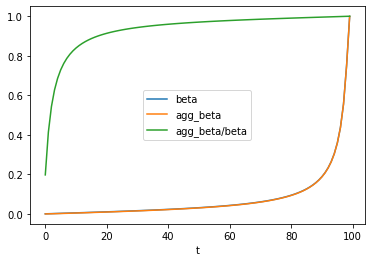

In [15]:
T = 100
beta, agg_beta = beta_and_agg[T]
ratio = agg_beta / beta

# SUSPICIOUS: The green line not starting @ 0
x = torch.arange(0, T)
plt.xlabel("t")
plt.plot(x, beta, label="beta")
plt.plot(x, agg_beta, label="agg_beta")
plt.plot(x, ratio, label="agg_beta/beta")
plt.legend()
plt.show()